In [1]:
# Cell 1: imports

import numpy as np
import torch
from scipy.ndimage import distance_transform_edt, label as nd_label, binary_erosion
import matplotlib.pyplot as plt


# 8 邻域结构
STRUCT_8 = np.ones((3, 3), dtype=bool)

# 和你类里面保持一致的默认参数
BACKGROUND_LABEL = 0
W0 = 10.0
SIGMA = 5.0

mask shape: (584, 565) num_classes: 256


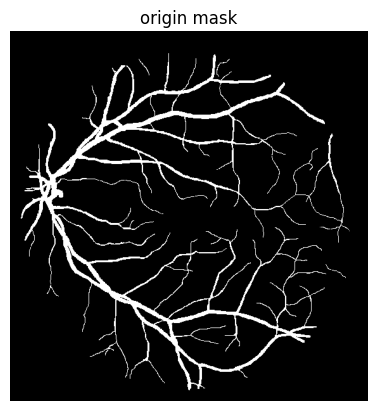

In [2]:
# Cell 2: 准备一张整型 mask [H, W]

# 示例：如果你已经有一个 batch，可以这样：
# batch = next(iter(train_loader))
# t = batch["mask"][0].cpu().numpy().astype(np.int32)  # [H, W]
from pathlib import Path
from torch.utils.data import DataLoader
from data_package.datasets.segmentation import ImageSegmentationDataset

mask_path = Path("./data/DRIVE/training/1st_manual/21_manual1.gif")
img_path = Path("./data/DRIVE/training/images/21_training.tif")

tmp_ds = ImageSegmentationDataset(
    image_paths=[img_path],   # 或同等数量的 image
    mask_paths=[mask_path],    # 这里必须是一个 mask 列表
    transform=None,
    weight_gen=None,
)

sample = tmp_ds[0]

mask = sample["mask"]
if isinstance(mask, torch.Tensor):
    t = mask.cpu().numpy().astype(np.int32)
else:
    t = np.asarray(mask, dtype=np.int32)

H, W = t.shape
num_classes = int(t.max() + 1)  # 或者你直接手动填，比如 2

print("mask shape:", t.shape, "num_classes:", num_classes)
plt.imshow(t, cmap="gray")
plt.title("origin mask")
plt.axis("off")
plt.show()


w_c_vec: [1.0807660e-06 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+

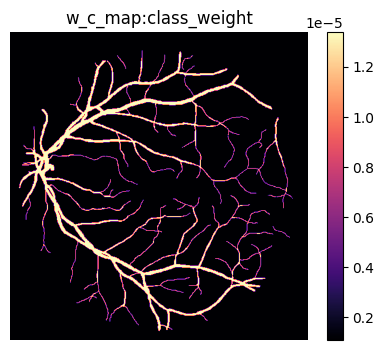

In [3]:
# Cell 3: 计算 w_c(x)，即每个像素的类别权重图

# 如果你以后想固定 class_weights，可以在这里直接给：
# class_weights = np.array([1.0, 2.0], dtype=np.float32)  # 举例
class_weights = None

if class_weights is None:
    flat = t.reshape(-1)
    hist = np.bincount(flat, minlength=num_classes).astype(np.float32)  # 每类像素个数
    total = hist.sum()
    if total > 0:
        freq = hist / total
        freq[freq == 0] = 1e-6
        med = np.median(freq[freq > 0])
        w_c_vec = med / freq    # [C]
    else:
        w_c_vec = np.ones((num_classes,), dtype=np.float32)
else:
    w_c_vec = np.asarray(class_weights, dtype=np.float32)
    assert len(w_c_vec) >= num_classes

print("w_c_vec:", w_c_vec)

# 映射到整张图上：w_c_map(x) = w_c_vec[t(x)]
w_c_map = w_c_vec[t]   # [H, W]

plt.figure(figsize=(5, 4))
plt.imshow(w_c_map, cmap="magma")
plt.title("w_c_map:class_weight")
plt.colorbar()
plt.axis("off")
plt.show()


num_inst = 19


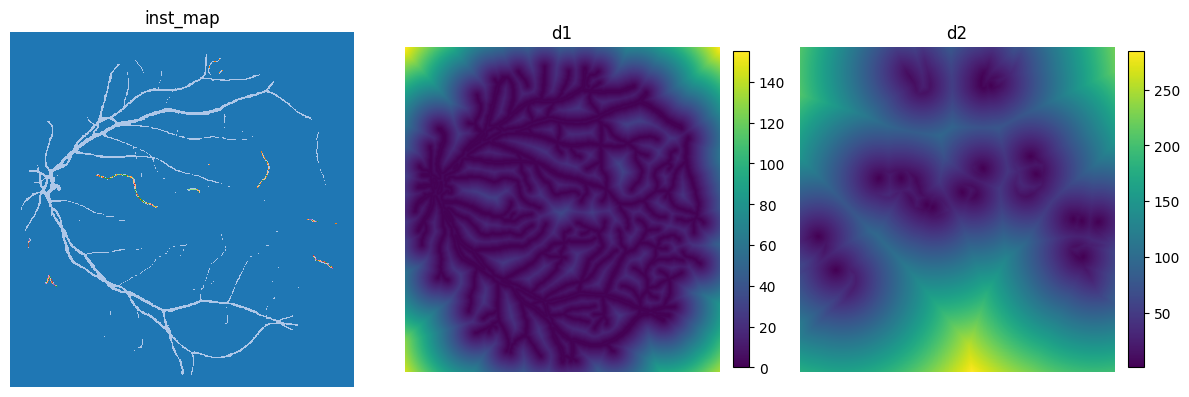

In [4]:
# Cell 4: 计算连通域 inst_map, 以及 d1, d2

bg = BACKGROUND_LABEL
fg_mask = (t != bg) # 布尔图

if not np.any(fg_mask) or W0 <= 0:
    print("没有前景或 W0 <= 0，分离项会是 0")
    inst_map = np.zeros_like(t, dtype=np.int32)
    d1 = np.zeros_like(t, dtype=np.float32)
    d2 = np.zeros_like(t, dtype=np.float32)
else:
    # 连通域标记：为每个前景实例分配 id 1,2,...,num_inst
    inst_map, num_inst = nd_label(fg_mask, structure=STRUCT_8)
    print("num_inst =", num_inst)

    dist_list = []
    for inst_id in range(1, num_inst + 1):
        inst_i = (inst_map == inst_id)

        # 统计该实例有多少个像素
        if inst_i.sum() == 0:
            continue

        # 边界 = 实例 - 腐蚀(实例)
        eroded_i = binary_erosion(inst_i, structure=STRUCT_8, border_value=0)
        boundary_i = inst_i ^ eroded_i
        if not np.any(boundary_i):
            continue

        # 对 "非边界" 做 EDT，得到到最近边界的距离
        dist_i = distance_transform_edt(~boundary_i)
        dist_list.append(dist_i.astype(np.float32))

    if len(dist_list) < 2:
        print("有效实例 < 2，无法形成 d1 + d2，分离项会是 0")
        d1 = np.zeros_like(t, dtype=np.float32)
        d2 = np.zeros_like(t, dtype=np.float32)
    else:
        distances = np.stack(dist_list, axis=0)        # [K, H, W]
        distances_sorted = np.sort(distances, axis=0)  # 按实例距离排序
        d1 = distances_sorted[0]
        d2 = distances_sorted[1]

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(inst_map, cmap="tab20")
axes[0].set_title("inst_map") # 连通域实例
axes[0].axis("off")

im1 = axes[1].imshow(d1, cmap="viridis")
axes[1].set_title("d1") # 最近实例边界距离
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(d2, cmap="viridis")
axes[2].set_title("d2") # 次近实例边界距离
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

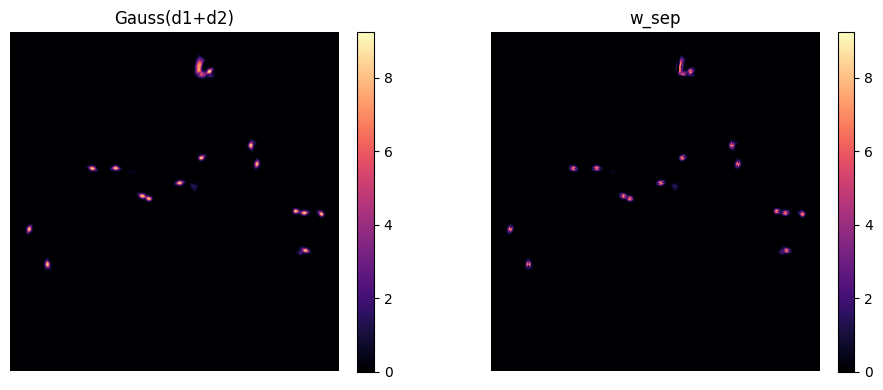

In [5]:
# Cell 5: 计算高斯分离项 w_sep(x)

if np.all(d1 == 0) and np.all(d2 == 0):
    w_sep = np.zeros_like(t, dtype=np.float32)
    gauss = np.zeros_like(t, dtype=np.float32)
else:
    gauss = W0 * np.exp(- ((d1 + d2) ** 2) / (2.0 * (SIGMA ** 2))).astype(np.float32)
    background_mask = (t == bg).astype(np.float32)
    w_sep = gauss * background_mask  # 只对背景有效

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im1 = axes[0].imshow(gauss, cmap="magma")
axes[0].set_title("Gauss(d1+d2)")
axes[0].axis("off")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(w_sep, cmap="magma")
axes[1].set_title("w_sep") # 只在背景上生效
axes[1].axis("off")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

[[1.080766e-06 1.080766e-06 1.080766e-06 ... 1.080766e-06 1.080766e-06
  1.080766e-06]
 [1.080766e-06 1.080766e-06 1.080766e-06 ... 1.080766e-06 1.080766e-06
  1.080766e-06]
 [1.080766e-06 1.080766e-06 1.080766e-06 ... 1.080766e-06 1.080766e-06
  1.080766e-06]
 ...
 [1.080766e-06 1.080766e-06 1.080766e-06 ... 1.080766e-06 1.080766e-06
  1.080766e-06]
 [1.080766e-06 1.080766e-06 1.080766e-06 ... 1.080766e-06 1.080766e-06
  1.080766e-06]
 [1.080766e-06 1.080766e-06 1.080766e-06 ... 1.080766e-06 1.080766e-06
  1.080766e-06]]


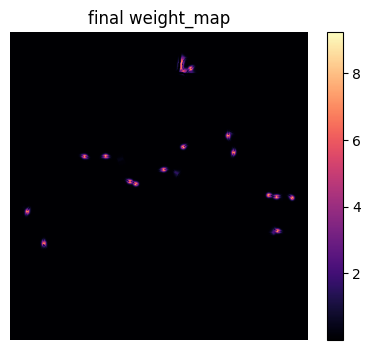

In [6]:
# Cell 6: 最终权重图

weight_map = w_c_map.astype(np.float32) + w_sep.astype(np.float32)

print(weight_map)

plt.figure(figsize=(5, 4))
plt.imshow(weight_map, cmap="magma")
plt.title("final weight_map")
plt.colorbar()
plt.axis("off")
plt.show()